___

**project**: `Human Stress Prediction (HSP)`

**date**: `2023-04-29`

**decription **: `In this notebook I'm going to create a simple AI classification model using NLP techniquies that will accurately classify human stress, if the human is stressed we detemine the type of stress the human is suffering from.`

**main**: `Natural Language Processing (NLP) pytorch`

**programmer**: `crispengari`

**architecture**: `BiDirectional Long Short Term Memory [BiLSTM] (torchtext)`

**language:** `python` 

____

In this project I will create a simple classifiation model that will be able to identify `stress` from humans based on their text and also detect what kind of stress is in this text.

### Data
The dataset that we going to use in this notebook we be comming from [kaggle](https://www.kaggle.com/datasets/kreeshrajani/human-stress-prediction). 

### Model Architecture
We are going to use `BiLSTM` in doing `multi-class` classifications of stress based on the textual sentences obtained from users. We are going to use the following notebook as reference:

> [11_SYMPTOMS_2_DISEASE_CLASSIFICATION](https://github.com/CrispenGari/nlp-pytorch/blob/main/11_SYMPTOMS_2_DISEASE_CLASSIFICATION/01_SYMPTOMS_2_DISEASE_CLASSIFICATION.ipynb)

### Installing Helper Packages
In the following code cell we are going to install the package called `helperfns` that provide us with some usefull helper functions for machine learning.

In [1]:
pip install helperfns -q

In the following code cell we are going to install the `wordcloud` package that we are going to use to visualize how frequently the word appears in the `copus`.

In [2]:
!pip install wordcloud -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Imports

In  the following code cell we are going to import all the packages that we are going to use throughout this `notebook`

In [3]:
import time
import json
import torch
import os
import random
import torchtext
from matplotlib import pyplot as plt
from torch import nn
from torchtext import data
from collections import Counter
from torchtext import vocab

from helperfns.tables import tabulate_data
from helperfns.visualization import plot_complicated_confusion_matrix, plot_simple_confusion_matrix
from helperfns.torch import models
from helperfns.utils import hms_string

import torch.nn.functional as F
import numpy as np
import pandas as pd
import wordcloud as wc

from google.colab import drive, files

torchtext.__version__, torch.__version__

('0.15.1+cpu', '2.0.0+cu118')

### Seed
In the following code cell we are going to set the seed to all random operations for reproducivity.

In [4]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Device
In the following code cell we are going to get `gpu` device if possible

In [5]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data

Our dataset that we are going to use will be comming from [`kaggle`](https://www.kaggle.com/datasets/kreeshrajani/human-stress-prediction) and will be loaded from google drive  where i uploaded it in a folder called `HSP`. So in the following code cell we are going to mount our google drive to this colab instance.

In [6]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Path to the dataset.
Now we can define the path as a variable to the location where our dataset file called `Stress.csv` is located.

In [7]:
base_dir = "/content/drive/My Drive/NLP Data/HSP"

assert os.path.exists(base_dir), f"The path '{base_dir}' does not exists."

data_path = os.path.join(base_dir, 'Stress.csv')

assert os.path.exists(data_path), f"The path '{data_path}' does not exists."

Then we need to read the `Stress.csv` file and create a classification dataset from it. For that we are going to use pandas and read the giant file into a dataframe as follows:

In [8]:
dataframe = pd.read_csv(data_path)
dataframe.head(10)

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005
5,relationships,7tx7et,"(30, 35)",I think he doesn't want to put in the effort f...,1,1.0,1517274027
6,domesticviolence,7iphly,"[25, 30]",It was a big company so luckily I didn't have ...,0,0.8,1512854409
7,anxiety,5m3k80,"(5, 10)",It cleared up and I was okay but. On Monday ...,1,0.8,1483582174
8,relationships,7nhy1v,"(50, 55)",I actually give an assistant half my emergency...,1,0.6,1514843984
9,assistance,61eiq6,"[15, 20]",I just feel like the street life has fucked my...,1,1.0,1490428087


In this dataframe we only care about 3 field which are `subreddit`, `label` and `text`. First let's check the classes or unique `subreddit` that we are going to have in this dataset. We only have `2` labels, if the person has stress(1) or not(0). From this dataset i can say `subreddit` is the type of stress this person is having.

In [9]:
stress_type = dataframe.subreddit.unique()
labels  = dataframe.label.unique()


{
    'stress_type': [stress_type, len(stress_type)],
    'labels': [labels, len(labels)]
}

{'stress_type': [array(['ptsd', 'assistance', 'relationships', 'survivorsofabuse',
         'domesticviolence', 'anxiety', 'homeless', 'stress',
         'almosthomeless', 'food_pantry'], dtype=object),
  10],
 'labels': [array([1, 0]), 2]}

So we have `10` different kind of stress people are suffering from in this dataset. In the following code cell we are going to extract `features` and `labels` from this giant dataframe so that we can create, different sets from it. So our labels will be transformed to textual labels which means if a person if `1` the person has stress and else a person does not have stress. We are also going to create a column where we are going to store the `stress_type`.

In [10]:
labels, features = ['stressed' if label == 1 else 'not stressed' for label in dataframe.label.values], [feature.lower() for feature in dataframe.text.values]

transfomers = {
    'ptsd': 'post-traumatic stress disorder',
    'assistance': 'assistance',
    'relationships': 'relationships', 
    'survivorsofabuse': 'survivors of abuse',
    'domesticviolence': 'domestic violence', 
    'anxiety': 'anxiety', 'homeless': 'homeless', 'stress': 'genaral stress',
    'almosthomeless': 'almost homeless', 'food_pantry': 'food pantry'
}

stress_types = [transfomers.get(t) for t in dataframe.subreddit.values]
labels[:2], features[:2], stress_types[:2]

(['stressed', 'not stressed'],
 ['he said he had not felt that way before, suggeted i go rest and so ..trigger ahead if youi\'re a hypocondriac like me: i decide to look up "feelings of doom" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid "are you psychic" test or new age b.s., something i could even laugh at down the road. no, i ended up reading that this sense of doom can be indicative of various health ailments; one of which i am prone to.. so on top of my "doom" to my gloom..i am now f\'n worried about my heart. i do happen to have a physical in 48 hours.',
  "hey there r/assistance, not sure if this is the right place to post this.. but here goes =) i'm currently a student intern at sandia national labs and working on a survey to help improve our marketing outreach efforts at the many schools we recruit at around the country. we're looking for current undergrad/grad stem students so if you're a stem student or know stem students, i would g

Here is what we are doing to clean the data. On the labels we did the following:

1. change the `labels` to text(either stressed or not stressed)

On the `stress_type` we:

1. created a dictionary map to map the values to something that human can understand.

On the `text` we just change them to a common case which is `lowercase`.


Now that we have converted all `features`, `stress_type` and `labels` into list of values with common case we can create a giant dataset from this in the following code cell.

In [11]:
assert len(features) == len(stress_types) == len(labels), f"The features and labels must be equal but got {len(stress_types) }, {len(stress_types)} and {len(labels)}."
dataset = list()
for feature, label, stress_type in zip(features, labels, stress_types):
   dataset.append((feature, label, stress_type))
print("Dataset size: {:,}".format(len(dataset)))

Dataset size: 2,838


We have a small dataset that contains `2,838` examples, let's check the first  example in the dataset:

In [12]:
dataset[0]

('he said he had not felt that way before, suggeted i go rest and so ..trigger ahead if youi\'re a hypocondriac like me: i decide to look up "feelings of doom" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid "are you psychic" test or new age b.s., something i could even laugh at down the road. no, i ended up reading that this sense of doom can be indicative of various health ailments; one of which i am prone to.. so on top of my "doom" to my gloom..i am now f\'n worried about my heart. i do happen to have a physical in 48 hours.',
 'stressed',
 'post-traumatic stress disorder')

Next we are going to use the `random` module to shuffle our dataset and then check again the size first examples before creating dataframes.

In [13]:
random.shuffle(dataset)

In [14]:
dataset[0]

('my version of events wasn\'t believed due to ten other witnesses denying it and i was expelled immediately. i got home and unexpectedly my bags were already packed. my sister-in-law walked up to me, gave me an insincere hug, and said "your actions have consequences. you\'re going to portland two weeks early." i asked if i could say goodbye to my nieces and nephews and friends and she said "no."',
 'stressed',
 'post-traumatic stress disorder')

So for our train data we are going to take all the examples in the `dataset` and then for the `validation` and `testing` set we are going to take a fraction of `40%` and `60%` from the dataset respectively.

In [15]:
train_df = pd.DataFrame(dataset, columns=["text", "label", "stress_type" ])

TEST_EXAMPLES = int(.6 * len(dataset))

random.shuffle(dataset)
test_df = pd.DataFrame(dataset[:TEST_EXAMPLES], columns=["text", "label", "stress_type" ])
val_df = pd.DataFrame(dataset[TEST_EXAMPLES: ], columns=["text", "label", "stress_type" ])

Checking our dataframes.


1. train dataframe

In [16]:
train_df.head(5)

,text,label,stress_type
0,my version of events wasn't believed due to te...,stressed,post-traumatic stress disorder
1,since i knew him i haven't had active suicidal...,stressed,domestic violence
2,"first, thanks to everyone that submitted a req...",not stressed,assistance
3,"i would comfort her as much as i was able, and...",not stressed,domestic violence
4,with my daughter recovering and my wife gettin...,stressed,assistance


2. test dataframe

In [17]:
test_df.head(5)

,text,label,stress_type
0,trauma changed the trajectory of my life. but ...,stressed,survivors of abuse
1,my sister lives with her bf and my 2 year old ...,not stressed,relationships
2,i have tried to her encourage her as best as i...,not stressed,relationships
3,"hey there r/assistance, not sure if this is th...",not stressed,assistance
4,"hi! this is my first time posting on reddit, a...",not stressed,homeless


3. validatation dataframe

In [18]:
val_df.head(5)

,text,label,stress_type
0,"for anxiety/depression. feb 16 weekend, we hun...",not stressed,anxiety
1,background: i didn't know much about ptsd when...,not stressed,post-traumatic stress disorder
2,"since then, i've been having major anxiety abo...",stressed,anxiety
3,"if you want to chat about anything, visit the ...",not stressed,survivors of abuse
4,until just a bit before i decide to move to th...,not stressed,homeless


Now that we have text matched to labels, we can go ahead and save the `csv` files for these 3 different sets of data

In [19]:
train_df.to_csv(os.path.join(base_dir, "train.csv"),  index = False, header = True)
test_df.to_csv(os.path.join(base_dir, "test.csv"),  index = False, header = True)
val_df.to_csv(os.path.join(base_dir, "val.csv"),  index = False, header = True)
print("Done")

Done


In the following code cell we are going to count the examples that are in each set of our whole dataset.

In [20]:
columns = ["Set", "Example(s)"]

examples = [
    ['training', len(train_df)],
    ['validation', len(val_df)],
    ['testing', len(test_df)],
    ['total', len(train_df) +  len(test_df) + len(val_df)],
]

tabulate_data(columns, examples, "Examples")

+------------+------------+
| Set        | Example(s) |
+------------+------------+
| training   |       2838 |
| validation |       1136 |
| testing    |       1702 |
| total      |       5676 |
+------------+------------+


### Features and Labels Extraction

Our fetures are the actual `text` in the dataframes which is the column named `text` and in this this task we have two labels that we need to accurately predict which is `label` (stressed, or not) and `stress_type` which is the type stress a human is having. In the following code cell we are going to read features and labels in a numpy arrays for each set.

In [21]:
# train
train_texts = train_df.text.values
train_labels = train_df.label.values
train_stress_types = train_df.stress_type.values

# test
test_texts = test_df.text.values
test_labels = test_df.label.values
test_stress_types = test_df.stress_type.values

# val
val_texts = val_df.text.values
val_labels = val_df.label.values
val_stress_types = val_df.stress_type.values

Let's check how frequently words appears in our dataset. We are going to use `wordcloud` the package that we have installed earlier to visualize that. We are going to check for the first `100` most appearing words.

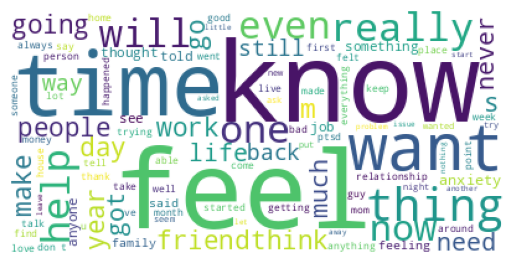

In [22]:
text = " ".join(train_texts)
wordcloud = wc.WordCloud(max_words=100, background_color="white").generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Next we are going to save our `wordcloud` file as follows:

In [23]:
wordcloud.to_file('wc.png')
print("Saved")

Saved


### Text Preprocessing
In our text processing pipeline we need to do the following steps:

1. tokenize sentences
* this is the process of converting a sentence or text into senquence of word. For this process we are going to use a pre-trained model from spacy language model. You can read more about other tokenizers that you can use at [pytorch](https://pytorch.org/text/stable/data_utils.html).org.

2. vocabulary
We will to create a vocabulary based on our sentences that are in the train dataset. A `vocabulary` is esentially a `word` to `index` mapping that allows us to reference the word with their integer representation, since machine leaning models does not understand words. This vocabulary will be used during model training and also can be used at model inference.

### Tokenizer
In the following code cell we are going to geta a tokenier object that will convert a sentence into a sequence of word using the `spacy-en` language model. The reason we are using the english langauge model it's because our intents are in english.

In [24]:
tokenizer = data.utils.get_tokenizer('spacy', 'en')
tokenizer("I love natural language processing (nlp).")

/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


['I', 'love', 'natural', 'language', 'processing', '(', 'nlp', ')', '.']

### Vocabulary
In the following code cell we are going to create a `vocabulary` object from torchtext. So we are going to use the `Counter` module from `collections` to generate these counts from our train features.

We are going to specify the `min_freq` to `2` meaning that the words that does not appear at least 2 times will be converted to unknown. We are also going to specify the special tokens during creation of the vocabulary object.

In [25]:
counter = Counter()
for line in train_texts:
    counter.update(tokenizer(line))
#  our special tokens are (unknown, padding, start of sentence, end of sentence)
vocabulary = vocab.vocab(counter, min_freq=2, specials=('-unk-', '-pad-', '-sos-', '-eos-'))

### STOI - String To Integer
This will be a dictionary that contains a string to integer mapping which will be our actual vocabulary. In the following code cell we are going to create object called `stoi` which is essentially a dictionary of word to index mapping. This dictionary will be used during training as well as during model inference.

In [26]:
stoi = vocabulary.get_stoi()

### Text Pipeline
After our text has been tokenized we need a way of converting those words into numbers because machine leaning models understand numbers not words. That's where we the `text_pipeline` function comes into play. So this function takes in a sentence and tokenize it then converts each word to a number. Note that the word that does not exists in the vocabulay (`stoi`) will be converted to  an unkown `('-unk-')` token (0).

In [27]:
def text_pipeline(x: str):
  values = list()
  tokens = tokenizer(x.lower()) # convert to lower case.
  for token in tokens:
    try:
      v = stoi[token]
    except KeyError as e:
      v = stoi['-unk-']
    values.append(v)
  return values

### Label pipeline
Our labels for now are just textual. We also need to convert these labels into numbers. This is very simple what we need to do is to get all the uniqe labels and then create a `labels_vocab` which is a label to integer representation. We are also going to do the same on `stress_type_labels`.

> As you have noticed we have `2` labels  and `10` stress types.

The `label_pipeline` and the `stress_type_label_pipeline` function will then takes in the label and then returns us an integer representation of that label.

In [28]:
labels_dict = {k: v for v, k in enumerate([d.lower() for d in train_df.label.unique()])}
stress_type_labels = {k: v for v, k in enumerate([d.lower() for d in train_df.stress_type.unique()])}

In [29]:
label_pipeline = lambda x: labels_dict[x]
stress_type_label_pipeline = lambda x: stress_type_labels[x]

Now that we have our vocabularies for labels `labels_dict`, `stress_type_labels` and  features `stoi` we can then save thes files as they will be used during model inference. We are going to save these files as `.json` files.

In [30]:
with open(os.path.join(base_dir, "vocab.json"), 'w') as f:
  f.write(json.dumps(stoi, indent=2))

with open(os.path.join(base_dir, "labels_dict.json"), 'w') as f:
  f.write(json.dumps(labels_dict, indent=2))

with open(os.path.join(base_dir, "stress_type_labels.json"), 'w') as f:
  f.write(json.dumps(stress_type_labels, indent=2))

print("Saved!!")

Saved!!


### Pretrained vectors
In the following code cell we are going to download the predtrained word vectors. We are going to use the `GloVe.6B.100d`. These are pretrained vectors that were trained with about `~6B` words and have a vector representation of a word in `100` dimension for each word.

In [31]:
EMBEDDING_DIM = 100
glove_vectors = vocab.GloVe('6B', dim=EMBEDDING_DIM)

### Creating Embedding matrix
Now that we have our glove vectors we need to costomize them so that they fit our use case. We are going to create an embedding matrix that suits the our vocabulary. So essentially this embedding matrix will be the word to vector mapping for all the words that arein our vocabulary.

In [32]:
VOCAB_SIZE = len(stoi)
EMBEDDING_MATRIX= torch.zeros([VOCAB_SIZE, EMBEDDING_DIM])
for i, word in enumerate(vocabulary.get_itos()):
  EMBEDDING_MATRIX[i] = glove_vectors[word]

In the followig code cell we are going to check the embedding matrix for the word `"stress"`.

In [33]:
EMBEDDING_MATRIX[stoi['stress']]

tensor([-0.7925,  0.1112, -0.1571,  0.3381, -1.5105, -0.2456, -1.0716, -0.3597,
        -0.6246,  0.2151, -0.3590, -0.3886,  0.1504,  0.4751,  0.3440,  0.0928,
        -0.7636, -0.3284, -0.1806, -0.6968,  0.0256, -0.2250, -1.0008,  0.4402,
        -0.4220,  0.2957, -0.1593, -0.4640,  0.3798, -0.0354, -0.2422,  0.1526,
        -0.2708,  0.0620, -0.1721, -0.2484,  0.4039,  0.4822, -0.4430,  0.4077,
        -0.4437,  0.0887, -0.0222, -0.4934, -0.3153,  0.2668,  0.0413,  0.1002,
        -0.3000, -1.0617,  0.1976, -0.7711, -0.2317,  0.7572,  0.7147, -1.4065,
         0.5392, -0.8503,  0.8112,  0.9346,  0.3804,  0.8510, -0.0968, -0.4487,
         0.7431,  0.8114,  0.1324, -0.7675,  0.4241, -0.3287, -0.4383,  0.1506,
        -0.0778,  0.3027,  0.6312,  0.6756,  0.1499, -0.3498, -0.1731,  0.1160,
         0.2834, -0.3573, -0.8868, -0.0051, -1.6313,  0.4051,  0.2360,  0.1223,
        -1.0897, -0.2883, -0.6558, -0.2405,  0.1284,  0.3390,  0.8172,  0.3133,
         0.6284, -1.1465,  0.6587,  0.12

### Creating Dataset for Training

In the following code cell we are going to create a dataset class called `HSPDataset`. This dataset will takes in the labels and the text of a set.

In [34]:
class HSPDataset(torch.utils.data.Dataset):
  def __init__(self, stress_types, labels, text):
    super(HSPDataset, self).__init__()
    self.labels = labels
    self.text = text
    self.stress_types = stress_types
      
  def __getitem__(self, index):
    return self.labels[index], self.stress_types[index], self.text[index]
  
  def __len__(self):
    return len(self.labels)

### collate_fn
We are going to create a collate function called `tokenize_batch`. This function actually takes in a `batch` and does the preprocessing of the text, stress_types and labels. This function will be passed to the `DataLoader` class to do the preprocessing of features and labels.

`tokenize_batch` function:

* this function takes in a batch in each set and convert the features and labels to integer representation. It goes ahead and `pad` and `truncate` the sequence to the same `length` and returns `labels`, `stress_types` and `features`.

In [35]:
def tokenize_batch(batch, max_len=100, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  labels_list, stress_types_list, text_list = [], [], []
  for _label, _type, _text in batch:
    labels_list.append(label_pipeline(_label))
    stress_types_list.append(stress_type_label_pipeline(_type))
    text_holder = torch.zeros(max_len, dtype=torch.int32)
    processed_text = torch.tensor(text_pipeline(_text.lower()), dtype=torch.int32)
    pos = min(max_len, len(processed_text))
    if padding == "pre":
      text_holder[:pos] = processed_text[:pos]
    else:
      text_holder[-pos:] = processed_text[-pos:]
    text_list.append(text_holder.unsqueeze(dim=0))
  #  the labels will be torch float tensors since they will go through a binary classification and stress-types will be lon tensors as it is a multi-class classification.
  return torch.FloatTensor(labels_list), torch.LongTensor(stress_types_list), torch.cat(text_list, dim=0)
  

### Datasets
In the following code cell we are going to create the datasets for all our three sets using the `HSPDataset` class.

In [36]:
train_dataset = HSPDataset(train_stress_types, train_labels, train_texts)
test_dataset = HSPDataset(test_stress_types, test_labels, test_texts)
val_dataset = HSPDataset(val_stress_types, val_labels, val_texts)

### Iterators
In the following code cell we are going to create loaders using the `DataLoader` class from `torch.utils.data` for our `3` sets. We are going to use the `batch_size` of `128` and our `collate_function` is `tokenize_batch`. For the validation and testing dataset we are going to set the shuffle to `False` because there's no need fo us to shuffle these examples.

In [37]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=tokenize_batch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)

Checking a single Batch Data

In [38]:
lbl, _types, txt = next(iter(train_loader))

Labels in the first batch.

In [39]:
lbl

tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0.,
        0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1.,
        1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0.,
        0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1.,
        1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
        0., 0.])

The stress types in the first batch.

In [40]:
_types

tensor([6, 2, 6, 0, 4, 2, 7, 2, 2, 3, 2, 3, 4, 3, 0, 7, 7, 3, 3, 0, 6, 3, 7, 6,
        6, 0, 3, 4, 7, 3, 2, 1, 4, 3, 2, 7, 4, 0, 3, 7, 3, 5, 0, 4, 7, 6, 3, 0,
        4, 0, 3, 0, 7, 0, 1, 0, 0, 7, 0, 7, 3, 5, 0, 3, 0, 9, 4, 0, 0, 4, 0, 4,
        4, 6, 6, 4, 3, 6, 3, 6, 0, 0, 4, 0, 5, 1, 2, 7, 6, 3, 3, 7, 3, 3, 3, 0,
        0, 2, 7, 2, 0, 7, 4, 2, 1, 7, 1, 0, 1, 2, 9, 8, 0, 7, 0, 7, 4, 0, 0, 1,
        0, 3, 0, 1, 8, 3, 7, 2])

The first sentence in the batch.

In [41]:
txt[0]

tensor([  19,  270,   54,    9,  786,   36,   76,  401,   19,   27, 3068,    8,
         691,  863,   74,  113,  566,  113,    8,  270,  287,  155,  213,   35,
          12, 1438,  127,   21,  546,   50,  408,   19,   54,    9,  241,   17,
          79,   18,  520,   89, 2719, 6184,   36,  334,  460,   34,  127,   35,
         476,   31,  835,  566,   19,   67,   44,  769,   89,  936, 4116,   12,
           4,  775,   18,    0,   44,   12, 1194,  127,   82,  566,   19,  330,
         331,  275,  210,   82,   19,   70,  493,    0,   18,   44,   62,   38,
         972,  973,   59,   19,    8, 1220,  566,   17,    8,   76,  248,  429,
          19,   54,  211,  566], dtype=torch.int32)

### Model Creation
Now that we have our loaders we can now create a model. The model that we are going to create is called `HSPModel`.  As mentioned we are going to use `BiDirectional Long Short Term Memory (BiLSTM)` to build this model. The model will process the text using the `embedding` layer and pass the outputs to the `ltsm` layers which is bidirectional, and process the features again. After the features has been processed then we are going to slit the training of each of the labels between:

1. label
2. and stress_type

We are going to name these linear layers which are processed sequentially `out1` and `out2` respectively, which means that in out `out1` we will be having the `output_size` of 1 since it will be a binary classification node and `out2` will have `10` `output_size` since it is a multi-class classification task.


````shell


                          |-------------> [out1] --- [1]
                          |
[embedding]--------->[bi-lstm]
                          |
                          |--------------> [out2] --- [10]
````

In [42]:
class HSPModel(nn.Module):
  def __init__(self, vocab_size, embedding_size, hidden_size, output_size1, output_size2 , num_layers
               , bidirectional, dropout, pad_idx):
    super(HSPModel, self).__init__()

    self.embedding = nn.Sequential(
        nn.Embedding(vocab_size, embedding_dim=embedding_size, padding_idx=pad_idx),
        nn.Dropout(dropout)
    )
    self.lstm = nn.Sequential(
        nn.LSTM(
          embedding_size, 
          hidden_size=hidden_size, 
          bidirectional=bidirectional, 
          num_layers=num_layers,
          dropout=dropout
        )
    )
    self.out1 = nn.Sequential(
        nn.Linear(hidden_size * 2, out_features=128),
        nn.Dropout(dropout),
        nn.Linear(128, out_features=output_size1),
        nn.Dropout(dropout)
    )
    self.out2 = nn.Sequential(
        nn.Linear(hidden_size * 2, out_features=128),
        nn.Dropout(dropout),
        nn.Linear(128, out_features=output_size2),
        nn.Dropout(dropout)
    )

  def forward(self, text, text_lengths):
    embedded = self.embedding(text)
    # set batch_first=true since input shape has batch_size first and text_lengths to the device.
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False, batch_first=True)
    packed_output, (h_0, c_0) = self.lstm(packed_embedded)
    output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
    output = torch.cat((h_0[-2,:,:], h_0[-1,:,:]), dim = 1)
    return self.out1(output), self.out2(output)

### Model Instance
In the following code cell we are going to create a model instance.

In [43]:
INPUT_DIM = len(stoi) 
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM_1 = 1
OUTPUT_DIM_2 = len(stress_type_labels)

N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = stoi['-pad-'] 
hsp_model = HSPModel(
              INPUT_DIM, 
              EMBEDDING_DIM, 
              HIDDEN_DIM, 
              OUTPUT_DIM_1, 
              OUTPUT_DIM_2,
              N_LAYERS, 
              BIDIRECTIONAL, 
              DROPOUT, 
              PAD_IDX
).to(device)
hsp_model

HSPModel(
  (embedding): Sequential(
    (0): Embedding(6394, 100, padding_idx=1)
    (1): Dropout(p=0.5, inplace=False)
  )
  (lstm): Sequential(
    (0): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
  )
  (out1): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (out2): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=128, out_features=10, bias=True)
    (3): Dropout(p=0.5, inplace=False)
  )
)

### Counting Model Parameters
In the following code cell we are going to count the model parameters.

In [44]:
models.model_params(hsp_model)

TOTAL MODEL PARAMETERS: 	3,082,291
TOTAL TRAINABLE PARAMETERS: 	3,082,291


### Loading Embedding Vectors
In the following code cell we are going to load the pretained custom vectors in our embedding layer. We are going to load the embedding vectors tha suits our data using the `mhcb_model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)` as follows:

In [45]:
hsp_model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.4764, -0.1772, -0.5788,  ...,  0.0338, -0.9605, -0.9339],
        [-0.3933,  0.2518, -0.3606,  ..., -0.4295, -0.3365,  0.1659],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

### Optimizer and Criterion

In the following code cell we are going to define the `optimizer` and `criterions`. For the `optimizer` we are going to use the `Adam` optimizer with default parameters and for the criterions or loss functions we are going to use two loss functions which are:

1. `CrossEntropyLoss()` function for our `stress-type` labels since this is a `multi-class` classification.

2. `BCEWithLogitsLoss()` function on our `labels` since this is a binary classification task.

In [46]:
optimizer = torch.optim.Adam(hsp_model.parameters())

criterion1 = nn.BCEWithLogitsLoss().to(device)
criterion2 = nn.CrossEntropyLoss().to(device)

In the following code cell we are going to create our `categorical_accuracy` and our `binary_accuracy` function, which are functions that calulates the the catecorical/binary accuracy between the predicted labels and real labels.

In [47]:
def categorical_accuracy(preds, y):
  top_pred = preds.argmax(1, keepdim = True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

def binary_accuracy(preds, y):
  rounded_preds = torch.round(torch.sigmoid(preds))
  correct = (rounded_preds == y).float()
  acc = correct.sum() / len(correct)
  return acc

### Train and Evaluate functions
In the following code cell we are going to create our `train` and `evalute` functions. Here is what is going to hapen during model training:

1. put the model in the train mode by calling `model.train()`
2. for each batch we are going to take, labels, stress_types and fetaures and put the to device
3. for the loss and accuracy we are going to calculate for each label using respective losss functions and accuracy functions.
4. we will return the losses and accuracy for each label.

> Note that the process is the same with the evaluate function except that we dont compute gradients and we put the model in evaluation model by calling `model.eval()`


In [48]:
def train(model, iterator, optimizer, criterion1, criterion2):
  epoch_loss_1, epoch_acc_1, epoch_loss_2, epoch_acc_2  = 0, 0, 0 , 0
  model.train()
  for batch in iterator:
    y_1, y_2, X = batch
    X = X.to(device)
    y_1 = y_1.to(device)
    y_2 = y_2.to(device)
    lengths = torch.tensor([len(i) for i in X])
    optimizer.zero_grad()

    out_1, out_2 = model(X, lengths)
    out_1, out_2 = out_1.squeeze(1), out_2.squeeze(1)

    loss_1 = criterion1(out_1, y_1)
    acc_1 = binary_accuracy(out_1, y_1)
    loss_2 = criterion2(out_2, y_2)
    acc_2 = categorical_accuracy(out_2, y_2)

    loss = loss_1 + loss_2
    loss.backward()

    optimizer.step()
    epoch_loss_1 += loss_1.item()
    epoch_acc_1 += acc_1.item()
    epoch_loss_2 += loss_2.item()
    epoch_acc_2 += acc_2.item()
  return epoch_loss_1 / len(iterator), epoch_acc_1 / len(iterator), epoch_loss_2 / len(iterator), epoch_acc_2 / len(iterator)

def evaluate(model, iterator, criterion1, criterion2):
  epoch_loss_1, epoch_acc_1, epoch_loss_2, epoch_acc_2  = 0, 0, 0 , 0
  model.eval()
  with torch.no_grad():
    for batch in iterator:
      y_1, y_2, X = batch
      X = X.to(device)
      y_1 = y_1.to(device)
      y_2 = y_2.to(device)
      lengths = torch.tensor([len(i) for i in X])
      out_1, out_2 = model(X, lengths)
      out_1, out_2 = out_1.squeeze(1), out_2.squeeze(1)

      loss_1 = criterion1(out_1, y_1)
      acc_1 = binary_accuracy(out_1, y_1)
      loss_2 = criterion2(out_2, y_2)
      acc_2 = categorical_accuracy(out_2, y_2)

      epoch_loss_1 += loss_1.item()
      epoch_acc_1 += acc_1.item()
      epoch_loss_2 += loss_2.item()
      epoch_acc_2 += acc_2.item()
  return epoch_loss_1 / len(iterator), epoch_acc_1 / len(iterator), epoch_loss_2 / len(iterator), epoch_acc_2 / len(iterator)

### Training Loop

In the following code cell we are going to run the training loop. We are going to save the model when the either one of the losses decreased from the previous loss stored. And we are also going to keep in track of our training history.

In [49]:
N_EPOCHS = 200
MODEL_NAME = 'hsp_model.pt'

# we need a way of keeping tracking the matrics
train_losses_1 = []
train_losses_2 = []
train_accuracies_1 = []
train_accuracies_2 = []
val_losses_1 = []
val_losses_2 = []
val_accuracies_1 = []
val_accuracies_2 = []

training_start = time.time()
best_valid_loss_1 = float('inf')
best_valid_loss_2 = float('inf')

last_saved_epoch = 0
for epoch in range(N_EPOCHS):
  start = time.time()
  train_loss_1, train_acc_1, train_loss_2, train_acc_2 = train(hsp_model, train_loader, optimizer, criterion1, criterion2)
  val_loss_1, val_acc_1, val_loss_2, val_acc_2 = evaluate(hsp_model, val_loader, criterion1, criterion2)
  title = f"EPOCH: {epoch+1:02}/{N_EPOCHS:02} {'saving best model...' if val_loss_1 < best_valid_loss_1 or val_loss_2 < best_valid_loss_2 else 'not saving...'}"
  if val_loss_1 < best_valid_loss_1 or val_loss_2 < best_valid_loss_2:
      best_valid_loss_1 = val_loss_1
      best_valid_loss_2 = val_loss_2
      last_saved_epoch = epoch
      torch.save(hsp_model.state_dict(), MODEL_NAME)
  end = time.time()

  # keep in track of all the metrics during training
  train_losses_1.append(train_loss_1)
  train_losses_2.append(train_loss_2)
  train_accuracies_1.append(train_acc_1)
  train_accuracies_2.append(train_acc_2)
  val_losses_1.append(val_loss_1)
  val_losses_2.append(val_loss_2)
  val_accuracies_1.append(val_acc_1)
  val_accuracies_2.append(val_acc_2)

  data = [
       ["Training", f'{train_loss_1:.3f}', f'{train_acc_1 * 100:.3f}%', f'{train_loss_2:.3f}', f'{train_acc_2 * 100:.3f}%', f"{hms_string(end - start)}" ],
       ["Validation", f'{val_loss_1:.3f}', f'{val_acc_1 * 100:.3f}%', f'{val_loss_2:.3f}', f'{val_acc_2 * 100:.3f}%', "" ],       
   ]
  columns = ["CATEGORY", "LOSS_1", "ACCURACY_1", "LOSS_2", "ACCURACY_2", "ETA"]
  print(title)
  tabulate_data(columns, data, title)

training_end= time.time()

EPOCH: 01/200 saving best model...
+------------+--------+------------+--------+------------+------------+
| CATEGORY   | LOSS_1 | ACCURACY_1 | LOSS_2 | ACCURACY_2 |        ETA |
+------------+--------+------------+--------+------------+------------+
| Training   |  0.688 |    54.799% |  2.215 |    17.922% | 0:00:05.80 |
| Validation |  0.670 |    62.103% |  2.115 |    19.829% |            |
+------------+--------+------------+--------+------------+------------+
EPOCH: 02/200 saving best model...
+------------+--------+------------+--------+------------+------------+
| CATEGORY   | LOSS_1 | ACCURACY_1 | LOSS_2 | ACCURACY_2 |        ETA |
+------------+--------+------------+--------+------------+------------+
| Training   |  0.674 |    58.603% |  2.182 |    18.846% | 0:00:05.50 |
| Validation |  0.660 |    63.889% |  2.115 |    23.735% |            |
+------------+--------+------------+--------+------------+------------+
EPOCH: 03/200 saving best model...
+------------+--------+--------

Let's check the training history of the model.

In [50]:
print("----- TOTAL TRAINING TIME ")
rows = [
      ["TOTAL EPOCHS", f'{N_EPOCHS}'],
      ["LAST SAVED EPOCH", f'{last_saved_epoch}'],
      ["TOTAL TRAINING TIME", f'{hms_string(training_end-training_start)}']
]
tabulate_data(['', 'value'], rows, "TOTAL TRAINING TIME")

----- TOTAL TRAINING TIME 
+---------------------+------------+
|                     |      value |
+---------------------+------------+
| TOTAL EPOCHS        |        200 |
| LAST SAVED EPOCH    |        199 |
| TOTAL TRAINING TIME | 0:09:39.39 |
+---------------------+------------+


### Evaluating the best model.
In the following code cell we are going to evaluate the best model using on the `test` data as follows:

In [51]:
columns = ["CATEGORY", "LOSS_1", "ACCURACY_1", "LOSS_2", "ACCURACY_2", "ETA"]
hsp_model.load_state_dict(torch.load(MODEL_NAME))
test_loss_1, test_acc_1, test_loss_2, test_acc_2 = evaluate(hsp_model, test_loader, criterion1, criterion2)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss_1:.3f}', f'{test_acc_1 * 100:.2f}%', f'{test_loss_2:.3f}', f'{test_acc_2 * 100:.2f}%', ""]]

tabulate_data(columns, data_rows, title)

+----------+--------+------------+--------+------------+-----+
| CATEGORY | LOSS_1 | ACCURACY_1 | LOSS_2 | ACCURACY_2 | ETA |
+----------+--------+------------+--------+------------+-----+
| Test     |  0.010 |     99.83% |  0.011 |     99.50% |     |
+----------+--------+------------+--------+------------+-----+


Let's visualize the training history of the model. In the following code cell we are going to plot line graphs of the losses and accuracy for all the labels.

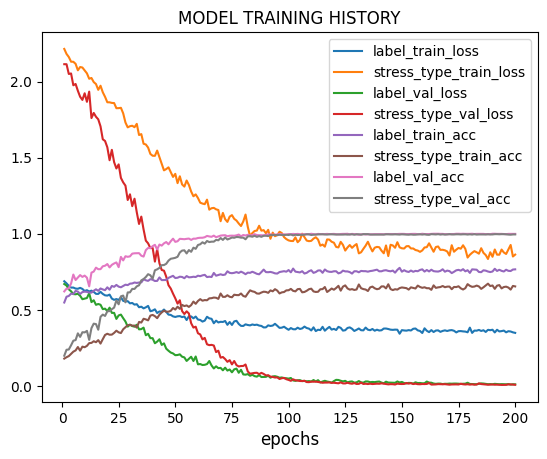

In [52]:
epochs = np.arange(1, N_EPOCHS + 1)
plt.plot(epochs, train_losses_1, label="label_train_loss")
plt.plot(epochs, train_losses_2, label="stress_type_train_loss")
plt.plot(epochs, val_losses_1, label="label_val_loss")
plt.plot(epochs, val_losses_2, label="stress_type_val_loss")

plt.plot(epochs, train_accuracies_1, label="label_train_acc")
plt.plot(epochs, train_accuracies_2, label="stress_type_train_acc")
plt.plot(epochs, val_accuracies_1, label="label_val_acc")
plt.plot(epochs, val_accuracies_2, label="stress_type_val_acc")

plt.title("MODEL TRAINING HISTORY", color="k", fontsize=12)
plt.legend()
plt.xlabel("epochs", fontsize=12)
plt.show()

### Model Inference
In the following code cell we are going to make predictions with the best model. We will have the function called `inference_preprocess_text` which is a function that process the text for inference.

In [53]:
def inference_preprocess_text(text, max_len=100, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  text_holder = torch.zeros(max_len, dtype=torch.int32) # fixed size tensor of max_len with  = 0
  processed_text = torch.tensor(text_pipeline(text), dtype=torch.int32)
  pos = min(max_len, len(processed_text))
  if padding == "pre":
    text_holder[:pos] = processed_text[:pos]
  else:
    text_holder[-pos:] = processed_text[-pos:]
  text_list= text_holder.unsqueeze(dim=0)
  return text_list

### Predicting Diseases

In the following code cell we are going to create a function that will be able to detect `stress` in textual data and also detemine the stress type that is detected in that text.

In [54]:

class Label:
  def __init__(self, label: str, labelId: int, confidence: float):
    self.label = label
    self.labelId = labelId
    self.confidence = confidence

  def __repr__(self) -> str:
    return f"[HSP Preciction: {self.label}]"

  def __str__(self) -> str:
    return f"[HSP Preciction: {self.label}]"

  def to_json(self):
    return {
        'label':  self.label,
        'labelId':  self.labelId,
        'confidence':  self.confidence,
    }


class Prediction:
  def __init__(self, text: str, label: Label, _type: Label):
    self.text = text
    self.label = label
    self._type = _type

  def __repr__(self) -> str:
    return f"[HSP Preciction: {self.label.label} - {self._type.label}]"

  def __str__(self) -> str:
    return f"[HSP Preciction: {self.label.label} - {self._type.label}]"

  def to_json(self):
    return {
        'text':  self.text,
        '_type':  self._type.to_json(),
        'label':  self.label.to_json(),
    }

In [55]:
dataset[0]

("trauma changed the trajectory of my life. but i don't know if i would feel this way about my options if i wasn't anxious and wounded. my ex and i broke up because he never liked to leave the house, even for daytime activities. i wonder sometimes how i am going to feel when i hit middle age. am i going to feel like i do now?",
 'stressed',
 'survivors of abuse')

In [56]:
def predict_stress(model, sentence, device): 
  model.eval()
  with torch.no_grad():
    tensor = inference_preprocess_text(sentence.lower()).to(device)
    length = torch.tensor([len(t) for t in tensor])
    out_1, out_2 = model(tensor, length)
    out_1, out_2 = torch.sigmoid(out_1.squeeze(0)), torch.softmax(out_2.squeeze(0), dim=0)

    prediction_1 = torch.round(out_1)
    prediction_2 = torch.argmax(out_2)

    prediction_1 = prediction_1.detach().cpu().item()
    prediction_2 = prediction_2.detach().cpu().item()

    stresses_types = {v:k for k, v in stress_type_labels.items()}
    labels_ = {v:k for k, v in labels_dict.items()}

    label_2 = stresses_types[prediction_2]
    label_1 = labels_[prediction_1]
      
    _label_1 = Label(label_1, int(prediction_1), float(round(1 - prediction_1 if prediction_1 < 0.5 else prediction_1, 2)))
    _label_2 = Label(label_2, int(prediction_2), float(round(out_2[prediction_2].item(), 2)))
    return Prediction(
        sentence.lower(), _label_1, _label_2
    )

predict_stress(hsp_model, dataset[0][0], device)

[HSP Preciction: stressed - survivors of abuse]

### Downloading the model.
We are going to download the model

In [57]:
files.download(MODEL_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>